## Heathcare Analytics Project

**Developers:**
1. Himanshu Bhavsar https://www.linkedin.com/in/himanshu-bhavsar/

**Project title: Prediction of total charges for inpatient discharge from hospitals**

## **Description:**

According to statista.com the per capita healthcare expenditure for the United States is highest in the world. This number is almost double than the country with the second highest per capital expenditure. This is a cause for concern for most people who are living below powerty line and cannot afford proper healthcare services. By analyzing the cost for inpatient discharges for a single state we can see the factors that influence this cost and can be replicated for all other states in the country.

## **Information about the dataset**:

This dataset contains de-identified data for inpatient discharges from hospitals based in the state of New York obtained from Statewide Planning and Research Cooperative System (SPARCS). This file contains discharge level details on patient characteristics, diagnoses, treatments, services, and charges for each hospital inpatient stay and outpatient (ambulatory surgery, emergency department, and outpatient services) visit.
This dataset contains 34 columns and 1 million rows detailing every aspect of patient discharge.

## **Project steps and outcome**:

I will be making a prediction model by analyzing the different features that influence the total cost and predicting the total cost for inpatient discharges.  I will also be making a web app that will demonstrate the working of this model by providing data and getting predictions in real time.

We have followed the following steps for this project.

1. Data Loading
2. Data cleaning
3. Exploratory Data Analysis
4. Data preparation for model
5. Model creation and training
6. Model evaluation
7. Final model extraction for web app.

## Loading required libraries

In [103]:
#importing libraries
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from pandas.api.types import is_string_dtype, is_object_dtype
from pandas.api.types import is_categorical_dtype
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump,load
from sklearn.metrics import mean_absolute_error, r2_score

## Loading the dataset into a pandas dataframe

In [49]:
#loading the dataset into a pandas dataframe
data = pd.read_csv('data_2015.csv', low_memory=False) #as we have over a million rows we have turned off the low memory flag

#printing the shape of the orignal dataset
print("Shape of orignal data", data.shape)

print("\n")

#printing the dataframe columns in transpose to get an idea about the data
print(data.head(5).T)

## Data cleaning and Exploratory data analysis

In [63]:

#during the initial testing phase we have identified the following columns that have very little effect on the accuracy. 
#hence removing such columns

data1 = data.drop(['Operating Certificate Number','Facility Name',
                'CCS Diagnosis Description','CCS Procedure Description',
                'APR DRG Description','APR MDC Description', 'Discharge Year',
                'APR Severity of Illness Description','Abortion Edit Indicator','Zip Code - 3 digits',
                'Emergency Department Indicator','Payment Typology 2','Payment Typology 3'], axis=1)

#checking for null values
print(data1.isnull().sum())

#dropping all the rows that contain null values
data1 = data1.dropna()

print("\n")

print("Shape of data after dropping NA rows", data1.shape)

#printing the unique values from the dataframe columns
print(data1.apply(lambda col: col.unique()))

#changing the data type of column length of stay
data1['Length of Stay'].replace({"120 +": "120"}, inplace=True)
data1['Length of Stay'] = data1['Length of Stay'].astype(str).astype(int)

Health Service Area                 2328
Hospital County                     2328
Facility Id                         2328
Age Group                              0
Gender                                 0
Race                                   0
Ethnicity                              0
Length of Stay                         0
Type of Admission                      0
Patient Disposition                    0
CCS Diagnosis Code                     0
CCS Procedure Code                     0
APR DRG Code                           0
APR MDC Code                           0
APR Severity of Illness Code           0
APR Risk of Mortality                 73
APR Medical Surgical Description       0
Payment Typology 1                     0
Birth Weight                           0
Total Charges                          0
Total Costs                            0
dtype: int64


Shape of data after dropping NA rows (1046173, 21)
Health Service Area                 [Western NY, Finger Lakes, Capital/Ad

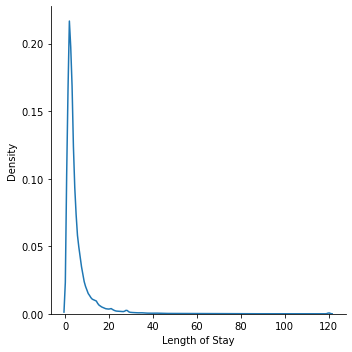

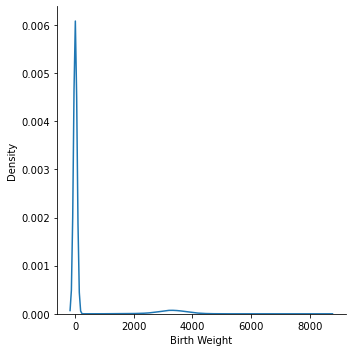

In [68]:
#checking the distribution of Length of stay

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.displot(data1, x="Length of Stay", kind="kde")

#checking the distribution of Birth weight
sns.displot(data1, x="Birth Weight", kind="kde")

<AxesSubplot:xlabel='Age Group', ylabel='count'>

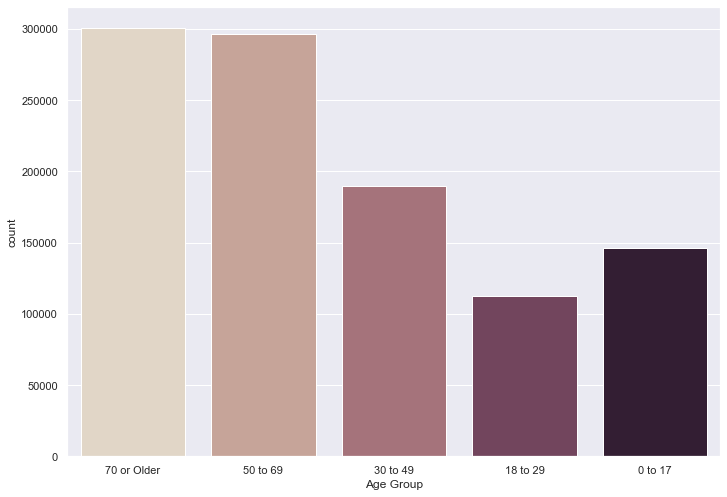

In [74]:
#plotting the distribution of age group
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(ax=ax, x="Age Group", palette="ch:.25", data=data1)

As we can see the majority patiens are from the 70 or older category followed by 50 to 69 years of age.

In [91]:
#upon futher inspection it was found that only the following columns have significant inpact on the model accuracy.

#storing these columns in a new dataframe
data_new = data1[['Hospital County','Age Group','Gender','Length of Stay','Type of Admission','Payment Typology 1','Total Charges','Total Costs']]

#our final dataset looks like this
data_new.head()

,Hospital County,Age Group,Gender,Length of Stay,Type of Admission,Payment Typology 1,Total Charges,Total Costs
0,Allegany,70 or Older,F,4,Urgent,Medicare,5333.90,4818.42
1,Allegany,70 or Older,F,4,Elective,Medicare,4865.99,4588.78
2,Allegany,70 or Older,F,4,Urgent,Medicare,5901.54,5559.56
3,Allegany,50 to 69,F,2,Elective,Medicare,3619.08,3567.25
4,Allegany,70 or Older,M,2,Elective,Medicare,3185.87,3167.89


## Data processing for the model



In [92]:
import warnings
warnings.filterwarnings("ignore")

# Functions to convert non-numeric to numeric - 1
def wkng_data1_string_to_cat(wkng_data1):
    for col in wkng_data1.columns:
        if is_string_dtype(wkng_data1[col]) or is_object_dtype(wkng_data1[col]):
            wkng_data1[col] = wkng_data1[col].astype('category').cat.as_ordered()

# Functions to convert non-numeric to numeric - 2
def wkng_data1_cat_to_catcode(wkng_data1):
    for col in wkng_data1.columns:
        if is_categorical_dtype(wkng_data1[col]):
            wkng_data1[col] = wkng_data1[col].cat.codes + 1

#applying functions on the dataset
wkng_data1_string_to_cat(data_new)

wkng_data1_cat_to_catcode(data_new)

#data1 = data1.head(40000)

#renaming columns for simplicity
data_new = data_new.rename(columns={"Hospital County": "hospitalcounty", 
                              "Age Group": "agegroup", 
                              "Gender": "gender",
                              "Length of Stay": "lengthofstay",
                              "Type of Admission": "admissiontype",
                              "Payment Typology 1": "paymentmethod",
                              "Total Charges": "totalcharges",
                              "Total Costs": "totalcosts"}, errors="raise")

#verifying that the rename worked sucessfully
print(data_new.info())

print("\n")

#labels are the values that we want to predict
labels = np.array(data_new['totalcharges'])

#removing labels from features
inputs = data_new.drop('totalcharges', axis = 1)

#saving cols name for future use
cols_list = list(data_new.columns)

#converting to numpy array
inputs = np.array(inputs)

#splitting the data into train and test sets for model training with test size 30% of the total data.
train_x, test_x, train_y, test_y = train_test_split(inputs, labels, test_size = 0.30, random_state = 9)

print("Shape of training inputs", train_x.shape)
print("Shape of training labels",train_y.shape)
print("Shape of testing data",test_x.shape)
print("Shape of testing labels",test_y.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1046173 entries, 0 to 1048573
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   hospitalcounty  1046173 non-null  int8   
 1   agegroup        1046173 non-null  int8   
 2   gender          1046173 non-null  int8   
 3   lengthofstay    1046173 non-null  int32  
 4   admissiontype   1046173 non-null  int8   
 5   paymentmethod   1046173 non-null  int8   
 6   totalcharges    1046173 non-null  float64
 7   totalcosts      1046173 non-null  float64
dtypes: float64(2), int32(1), int8(5)
memory usage: 65.2 MB
None


Shape of training inputs (732321, 7)
Shape of training labels (732321,)
Shape of testing data (313852, 7)
Shape of testing labels (313852,)


In [94]:
#saving the test files for further use
np.savetxt("test_x.csv", test_x, delimiter=",")
np.savetxt("test_y.csv", test_y, delimiter=",")

## Creating the model and evaluating

In [95]:
#initializing the model
model = RandomForestRegressor(n_estimators = 200, #using RandomForestRegressor with n_estimator 200 and metric=oob_score 
                              oob_score=True, 
                              n_jobs = -1, 
                              random_state = 9)

model.fit(train_x, train_y) #fitting the model on training data
oob_score = model.oob_score_  #obtaining the oob score
print(f" {oob_score:f}", end='') #printing the oob score

 0.926660

In [101]:
#using the .predict method on the model to get predictions from the test data
pred = model.predict(test_x)

#comparing predicted and actual values
print("Printing top 4 values from the predictions:", pred[0:4])

print("\n")

print("Printing top 5 values fromt the test labels", test_y[0:4])

Printing top 4 values from the predictions: [ 19671.62745  30791.9516   19250.45665 149304.76575]


Printing top 5 values fromt the test labels [ 23973.53  31344.62  18988.1  154776.05]




In [104]:
#creating emptly list for storing final metrics
train_r2 = []
train_mae = []
test_r2 = []
test_mae = []
oob_scores = []
  
#applying predict function on the train data
train_preds = model.predict(train_x)
    
#getting the r2 score
train_r2.append(round(r2_score(train_y, train_preds), 4))
test_r2.append(round(r2_score(test_y, pred), 4))

#getting the Mean absolute error
train_mae.append(round(mean_absolute_error(train_y, train_preds), 0))
test_mae.append(round(mean_absolute_error(test_y, pred), 0))

#getting the oob score
oob_scores.append(round(model.oob_score_, 4))

#printing everything
print("Train r2 scores: \n", train_r2)
print("")
print("Test r2 scores: \n", test_r2)
print("")
print("Train MAE scores: \n", train_mae)
print("")
print("Test MAE scores: \n", test_mae)
print("")
print("oob_scores: \n", oob_scores)

Train r2 scores: 
 [0.99]

Test r2 scores: 
 [0.923]

Train MAE scores: 
 [2140.0]

Test MAE scores: 
 [5892.0]

oob_scores: 
 [0.9267]


## Saving the model file for web api processing

In [96]:
#using dump from the joblib library, saving the model in .joblib format for further use
dump(model,'modelpredictorengine.joblib')

['modelpredictorengine.joblib']